In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fresnel_propag as prop
from misc import gauss2D
import zernike as zern

# Simulation of z-scan

## Laser parameters

In [2]:
lam = 8e-7 # Wavelength (in m)
k = 2*np.pi/lam # Wave vector
fwhm = 0.07 # Input full-width at half-maximum

f = 2 # Focal length (in m)

## Simulation parameters

In [3]:
L1 = 0.3 # Input plane dimension (in m)
L2 = 5e-4 # Output plane dimension (in m)

Nz = 100 # Number of longitudinal positions
N = 200 # Number of transverse points

x1 = np.linspace(0, L1, num=N) - L1/2 # Input plane transverse axis
x2 = np.linspace(0, L2, num=N) - L2/2 # Output plane transverse axis
z_scan = f + np.linspace(-1e-2, 1e-2, num=Nz) # Longitudinal axis

X1, Y1 = np.meshgrid(x1,x1) # Build 2D trasnverse axes
# The fresnel_propag module needs a 2D input field,
# to just have a 1D simulation, do "np.meshgrid(x1,0)",
# and the result of "prop.prop_two_steps" below can be flattened

## Propagation

In [4]:
%%time
# 100 x 200 x 200 -> about 2 sec on a standard Windows 7 desktop computer

# Define input electric field
u1 = gauss2D(X1, Y1, fwhm, fwhm, order=6) # 6th order super-Gaussian beam

# Add perfect lens (focal length f) to focus the beam
u1 = u1*np.exp( -1j * k / 2 / f * ( X1**2 + Y1**2 ) )

# Add a bit of wavefront aberration
Rho, Theta = zern.cart2pol(X1/(1.1*fwhm/2), Y1/(1.1*fwhm/2)) # Scale the FWHM by 1.1 to include the wings of the profile
astig0 = zern.zernike_map(Rho, Theta, (2,2)) # 1 lambda RMS amplitude
astig45 = zern.zernike_map(Rho, Theta, (2,-2))
coma0 = zern.zernike_map(Rho, Theta, (3,1))
coma90 = zern.zernike_map(Rho, Theta, (3,-1))
trefoil0 = zern.zernike_map(Rho, Theta, (3,3))
trefoil30 = zern.zernike_map(Rho, Theta, (3,-3))
wavefront = 0.1*coma0 - 0.1*astig45
u1 = u1*np.exp(1j * 2*np.pi * wavefront) # Add to spatial phase

# Initialise output electric field
u2 = np.complex64(np.zeros([Nz,N,N]))

# Propagate the input field for every z
for idx, z in enumerate(z_scan):
    u2[idx,:] = prop.prop_two_steps(u1, L1, L2, lam, z)

i2 = np.abs(u2)**2

Wall time: 1.63 s


## Display z-scan

In [5]:
# Extract slices
i2_hor = np.squeeze(i2[:, np.int(N/2-1), :])
i2_ver = np.squeeze(i2[:, :, np.int(N/2-1)])
i2_focus = np.squeeze(i2[np.int(Nz/2-1), :, :])

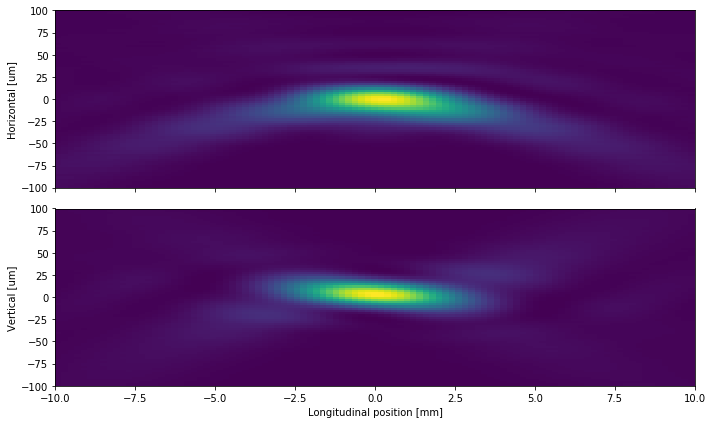

In [6]:
# Z-scan
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
ax[0].pcolormesh((z_scan-f)*1e3, x2*1e6, i2_hor.T)
ax[0].set_ylabel('Horizontal [um]')
ax[0].set_ylim(-100,100)

ax[1].pcolormesh((z_scan-f)*1e3, x2*1e6, i2_ver.T)
ax[1].set_ylabel('Vertical [um]')
ax[1].set_xlabel('Longitudinal position [mm]')
ax[1].set_ylim(-100,100)
fig.tight_layout()

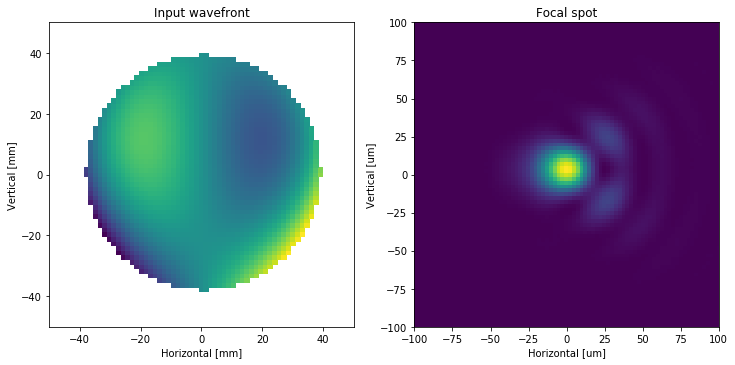

In [7]:
# Focus
wave_plot = np.ma.masked_array(wavefront, mask = Rho>1)

fig2, ax2 = plt.subplots(1,2,figsize=(12,6))

ax2[0].pcolormesh(x1*1e3,x1*1e3,wave_plot)
ax2[0].set_aspect('equal')
ax2[0].set_xlabel('Horizontal [mm]')
ax2[0].set_ylabel('Vertical [mm]')
ax2[0].set_xlim(-50,50)
ax2[0].set_ylim(-50,50)
ax2[0].set_title('Input wavefront')

ax2[1].pcolormesh(x2*1e6,x2*1e6,i2_focus)
ax2[1].set_aspect('equal')
ax2[1].set_xlabel('Horizontal [um]')
ax2[1].set_ylabel('Vertical [um]')
ax2[1].set_xlim(-100,100)
ax2[1].set_ylim(-100,100)
ax2[1].set_title('Focal spot');